# Fitting impedance spectra

## 1. Import and initialize equivalent circuit(s)

To begin we will import the Randles' circuit and a custom circuit from the impedance package. A full list of currently available circuits are available in the [documentation](https://impedancepy.readthedocs.io/en/latest/circuits.html).

In [1]:
from impedance.models.circuits import Randles, CustomCircuit

The classes we just imported represent different equivalent circuit models. To actually use them we want to initialize a specific instance and provide an initial guess for the parameters and any other options.

*E.g. for the randles circuit, one of the options is for a constant phase element (CPE) instead of an ideal capacitor.*

In [2]:
randles = Randles(initial_guess=[.01, .005, .001, 200, .1])
randlesCPE = Randles(initial_guess=[.01, .005, .001, 200, .1, .9], CPE=True)

Defining the custom circuit works a little differently. Here we pass a string comprised of the circuit elements grouped either in series (separated with a `-`) or in parallel (using the form `p(X,Y)`). Each element can be appended with an integer (e.g. `R0`) or an underscore and an integer (e.g. `CPE_1`) to make keeping track of multiple elements of the same type easier.

In [3]:
customCircuit = CustomCircuit(initial_guess=[.01, .005, .1, .005, .1, .001, 200],
                              circuit='R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1')

As of version 0.4, you can now specify values you want to hold constant. For example,

In [4]:
customConstantCircuit = CustomCircuit(initial_guess=[None, .005, .1, .005, .1, .001, None],
                                      constants={'R_0': 0.02, 'Wo_1_1': 200},
                                      circuit='R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1')

Each of the circuit objects we create can be printed in order to see the properties that have been defined for that circuit.

In [5]:
print(customConstantCircuit)


Circuit string: R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1
Fit: False

Constants:
    R_0 = 2.00e-02 [Ohm]
  Wo_1_1 = 2.00e+02 [sec]

Initial guesses:
    R_1 = 5.00e-03 [Ohm]
    C_1 = 1.00e-01 [F]
    R_2 = 5.00e-03 [Ohm]
    C_2 = 1.00e-01 [F]
  Wo_1_0 = 1.00e-03 [Ohm]



## 2. Formulate data

Several convenience functions for importing data exist in the impedance.preprocessing module, including one for reading simple `.csv` files where frequencies are stored in the first column, real parts of the impedance are in the second column, and imaginary parts of the impedance are in the third column.

In [6]:
from impedance import preprocessing

frequencies, Z = preprocessing.readCSV('../../../data/exampleData.csv')

# keep only the impedance data in the first quandrant
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

## 3. Fit the equivalent circuits to a spectrum

Each of the circuit classes has a `.fit()` method which finds the best fitting parameters.

After fitting a circuit, the fit parameters rather that the inital guesses are shown when printing.

In [7]:
randles.fit(frequencies, Z)
randlesCPE.fit(frequencies, Z)
customCircuit.fit(frequencies, Z)
customConstantCircuit.fit(frequencies, Z)

print(customConstantCircuit)


Circuit string: R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1
Fit: True

Constants:
    R_0 = 2.00e-02 [Ohm]
  Wo_1_1 = 2.00e+02 [sec]

Initial guesses:
    R_1 = 5.00e-03 [Ohm]
    C_1 = 1.00e-01 [F]
    R_2 = 5.00e-03 [Ohm]
    C_2 = 1.00e-01 [F]
  Wo_1_0 = 1.00e-03 [Ohm]

Fit parameters:
    R_1 = 6.79e-03  (+/- 1.08e-03) [Ohm]
    C_1 = 5.62e+00  (+/- 1.96e+00) [F]
    R_2 = 3.91e-03  (+/- 1.09e-03) [Ohm]
    C_2 = 1.36e+00  (+/- 2.61e-01) [F]
  Wo_1_0 = 5.88e-02  (+/- 1.25e-03) [Ohm]



## 4a. Predict circuit model and visualize with matplotlib

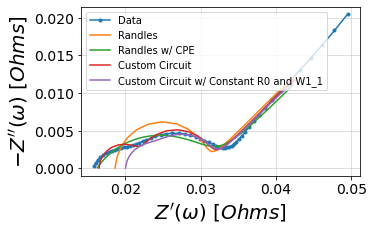

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from impedance.visualization import plot_nyquist

f_pred = np.logspace(5,-2)

randles_fit = randles.predict(f_pred)
randlesCPE_fit = randlesCPE.predict(f_pred)
customCircuit_fit = customCircuit.predict(f_pred)
customConstantCircuit_fit = customConstantCircuit.predict(f_pred)

fig, ax = plt.subplots(figsize=(5,5))

plot_nyquist(Z, ax=ax)
plot_nyquist(randles_fit, fmt='-', ax=ax)
plot_nyquist(randlesCPE_fit, fmt='-', ax=ax)
plot_nyquist(customCircuit_fit, fmt='-', ax=ax)
plot_nyquist(customConstantCircuit_fit, fmt='-', ax=ax)

ax.legend(['Data', 'Randles', 'Randles w/ CPE', 'Custom Circuit', 'Custom Circuit w/ Constant R0 and W1_1'])
plt.show()

## 4b. Or use the convenient plotting method included in the package

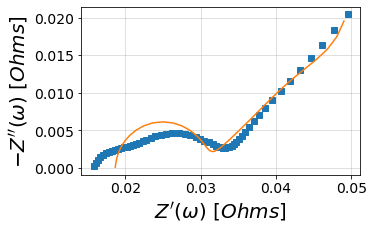

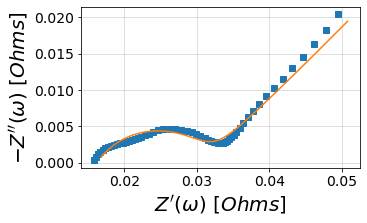

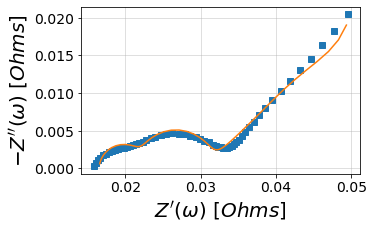

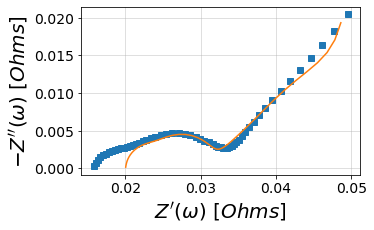

In [9]:
randles.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
randlesCPE.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
customConstantCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')

plt.show()

### Custom circuit elements using the @element decorator

In [10]:
from impedance.models.circuits.elements import element

@element(1, units=["hands"])
def H(p, f):
    """ A 'pointless' circuit element
    
    Parameters
    ----------
    p : list of numeric
        a list of parameters, e.g. p[0] is used as the radius below
    f : list of numeric
        a list of frequencies in Hz
        
    Returns
    -------
    Z : array of complex
        custom elements should return an array of complex impedance values
    """
    omega = 2*np.pi*np.array(f)
    return p[0]*np.cos(omega) + p[0]*1j*np.sin(omega)

#### Once we've defined our custom element, it can be used in a CustomCircuit

/Users/matt/Dropbox/matt/projects/impedance.py/ECSHackWeek/impedance.py/impedance/models/circuits/circuits.py:166: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


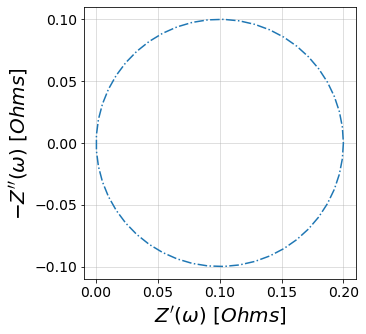

In [11]:
customElementCircuit = CustomCircuit(initial_guess=[0.1, 0.1], circuit='R_0-H_1')

f_pred = np.linspace(0, 1)

customElementCircuit_fit = customElementCircuit.predict(f_pred)

fig, ax = plt.subplots(figsize=(5,5))
plot_nyquist(customElementCircuit_fit, fmt='-.', ax=ax)
plt.show()